# High-Throughput Phenotyping in Rice Grains
### RGB - IMAGES (Found)

In [23]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def visualize_and_analyze_hyper_image(folder_path, threshold=70):
    results = []

    for file in os.listdir(folder_path):
        if file.lower().endswith('.tiff'):
            tiff_path = os.path.join(folder_path, file)
            img = cv2.imread(tiff_path, cv2.IMREAD_GRAYSCALE)

            # Thresholding
            _, segmented = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

            # Morphological Opening operation to separate close grains
            kernel = np.ones((3, 3), np.uint8)
            opened = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, kernel)

            # Find contours
            contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Draw contours on original image
            contour_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

            # Prepare visualization
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 3, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Original Image - {file}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(segmented, cmap='gray')
            plt.title('Segmented Image')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(contour_img)
            plt.title('Segmented Image with Counted Grains')
            plt.axis('off')

            plt.show()

            # Analysis
            major_axes = []
            minor_axes = []
            for contour in contours:
                if len(contour) >= 5:
                    ellipse = cv2.fitEllipse(contour)
                    major_axes.append(max(ellipse[1]))
                    minor_axes.append(min(ellipse[1]))

            num_grains = len(contours)
            median_major_axis = np.median(major_axes) if major_axes else 0
            median_minor_axis = np.median(minor_axes) if minor_axes else 0

            # Append analysis results
            results.append({
                'Image Name': file,
                'Number of Isolated Grains': num_grains,
                'Median Major Axis': median_major_axis,
                'Median Minor Axis': median_minor_axis,
            })

            # Chalky grain analysis
            gray_image = cv2.imread(tiff_path, cv2.IMREAD_GRAYSCALE)
            _, thresholded_image = cv2.threshold(gray_image, 45, 255, cv2.THRESH_BINARY)
            kernel = np.ones((5,5), np.uint8)
            segmented_without_background = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
            chalky_only_image = cv2.bitwise_and(gray_image, gray_image, mask=segmented_without_background)
            _, thresh = cv2.threshold(chalky_only_image, 120, 255, cv2.THRESH_BINARY)
            area_chalky = cv2.countNonZero(thresh)
            area_total_grains = cv2.countNonZero(segmented_without_background)
            percentage_chalky = (area_chalky / area_total_grains) * 100

            # Add chalky grain analysis results
            results[-1]['Area of Chalky Grains'] = area_chalky
            results[-1]['Total Area of Isolated Grains'] = area_total_grains
            results[-1]['Percentage of Chalky Grains (%)'] = percentage_chalky

    # Saving results to Excel
    df_results = pd.DataFrame(results)
    excel_path = os.path.join(folder_path, "grain_measurements.xlsx")
    df_results.to_excel(excel_path, index=False)
    print(f"Excel file saved at: {excel_path}")
    print(df_results)

# Usage
folder_path = 'D:\\Rice grain image dataset\\hyper'
#visualize_and_analyze_hyper_image(folder_path)


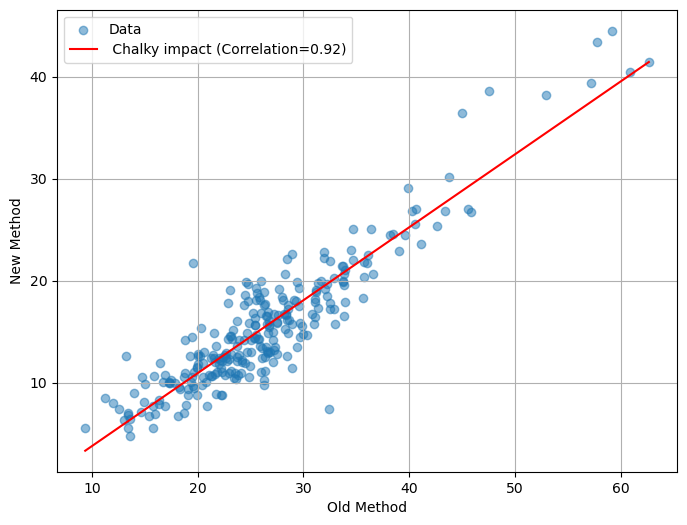

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Carregar os dados do arquivo Excel
df = pd.read_excel('D:\\Python\\correlação.xlsx')

# Clean data by removing rows with null values
df = df.dropna(subset=['Chalk impact', 'Percentage of Chalky Grains (%)'])

# Extract relevant columns
chalk_impact = df['Chalk impact']
percentage_chalky_grains = df['Percentage of Chalky Grains (%)']

# Calculate the correlation between the columns
correlation = chalk_impact.corr(percentage_chalky_grains)

# Calculate the trend line using linear regression
slope, intercept, _, _, _ = linregress(chalk_impact, percentage_chalky_grains)
trendline_x = np.linspace(chalk_impact.min(), chalk_impact.max(), 100)
trendline_y = slope * trendline_x + intercept

# Plot the scatter plot with the trend line
plt.figure(figsize=(8, 6))
plt.scatter(chalk_impact, percentage_chalky_grains, alpha=0.5, label='Data')
plt.plot(trendline_x, trendline_y, color='red', label=f' Chalky impact (Correlation={correlation:.2f})')
plt.title('')
plt.xlabel('Old Method')
plt.ylabel('New Method')
plt.grid(True)
plt.legend()
plt.show()


# Data evaluated in Bil files. 
# All data will now refer to hyper images

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import spectral as sp

# Path to the folder with hyperspectral images
image_directory = 'D:\\Rice grain image dataset\\hyper\\segundo'

# List to store the results
results = []

# Process each file in the directory
for file in os.listdir(image_directory):
    try:
        if file.endswith('.bil'):  # Adjust as needed for your file extension
            full_path = os.path.join(image_directory, file)
            hdr_path = full_path + '.hdr'  # Assuming .hdr accompanies the .bil
            img = sp.io.envi.open(hdr_path, full_path)
            
            # Select the specific band for analysis
            reference_band = 150
            band = img.read_band(reference_band)
            
            # Segmentation and specific analysis, as in the RGB example
            # Converting the band to 8-bit if necessary
            band_8bit = ((band - band.min()) / (band.ptp())) * 255
            band_8bit = band_8bit.astype('uint8')

            _, thresh = cv2.threshold(band_8bit, 45, 255, cv2.THRESH_BINARY)
            kernel = np.ones((5,5), np.uint8)
            segmented = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            # Calculation of areas and percentage
            area_total_grains = cv2.countNonZero(segmented)
            _, thresh_gessados = cv2.threshold(band_8bit, 120, 255, cv2.THRESH_BINARY)
            area_gessados = cv2.countNonZero(thresh_gessados)
            percentage_gessados = (area_gessados / area_total_grains) * 100 if area_total_grains else 0

            # Add results to the list
            results.append({
                'Image Name': file,
                'Total Area of Isolated Grains': area_total_grains,
                'Area of Chalky Grains': area_gessados,
                'Percentage of Chalky Grains (%)': percentage_gessados
            })
    except Exception as e:
        print(f'Error processing image {file}: {e}')

# Create DataFrame and save to Excel
#df_results = pd.DataFrame(results)
#excel_path = 'results_hyper_final.xlsx'
#df_results.to_excel(excel_path, index=False)

#print(f'Processing completed. The results have been saved to the file "{excel_path}".')
